## Kuznetsov Kristian - HW1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.tenalg import khatri_rao
from tensorly.random import random_cp
from tensorly.cp_tensor import cp_normalize, cp_to_tensor, CPTensor, cp_norm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from utils import *

import scipy.io

### Task 1

**(1.1)** (Upper Left): $y_{i,j,k,l} = \displaystyle \sum_{r_1, r_2, r_3, r_4, r_5} a_{i,r_1} \circ b_{j, r_2} \circ c_{r_1, r_2, r_3} \circ d_{r_3, r_4, r_5} \circ e_{r_4, k} \circ q_{r_5, l}$

**(1.2)** (Upper Right): $y_{i,j,k,l} = \displaystyle \sum_{r_1, r_2, r_3} a_{i, r_1} \circ c_{r_1, j, r_2} \circ d_{r_2, k, r_3} \circ e_{r_3, l, r_1}$

**(1.3)** (Lower Left): $y_{i,j,k} = \displaystyle \sum_{r_1, r_2, r_3} a_{r_1, i, r_2} \circ b_{r_2, j, r_3} \circ c_{r_3, k, r_1}$

**(1.4)** (Lower Right): $y_{i,j,k} = \displaystyle \sum_{r_1, r_2, r_3, r_4, r_5} a_{i, r_1} \circ b_{r_1, r_2, r_4} \circ c_{r_2, j, r_3} \circ d_{r_3, r_5, r_4} \circ e_{r_5, k}$

### Task 2

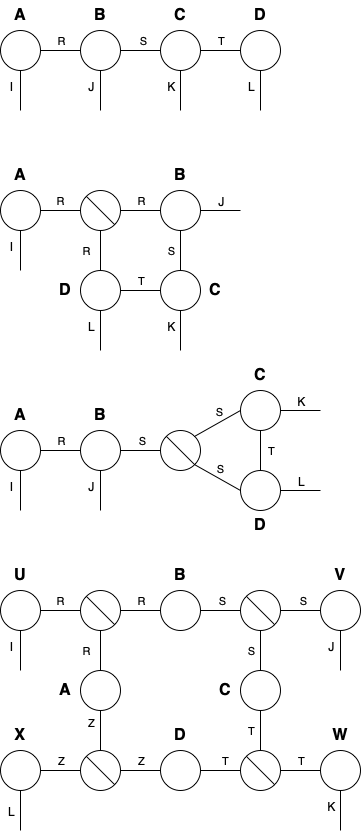

In [2]:
from IPython.display import Image
Image("TT.png")

### Task 3

We want to factorize matrix $\mathbf{Y}$:
$$\min _{\mathbf{A}, \mathbf{B}}\|\mathbf{Y}-\mathbf{A} \odot \mathbf{B}\|_{F}^{2}$$

We can see that:
$$\|\mathbf{Y}-\mathbf{A} \odot \mathbf{B}\|_{F}^{2} = \| [y_1, y_2, ..., y_n]- [a_1 \otimes b_1, a_2 \otimes b_2, ..., a_n \otimes b_n]\|_{F}^{2} = \sum_{r} \|y_r - a_r \otimes b_r\|_{2}^{2}$$

We can use the property that $a_r \otimes b_r = \text{vec}(b_r a_r^T)$ and then we apply reshaping to get rid of the vectorization:

$$\sum_{r} \|y_r - a_r \otimes b_r\|_{2}^{2} = \sum_{r} \|y_r - \text{vec}(b_r a_r^T)\|_{2}^{2} = \sum_{r} \|Y_r - b_r a_r^T\|_{2}^{2}$$

So here in each step we should find best rank-1 approximation of matrix, so we will just use SVD.

In [3]:
def TwoFactors_KhatriRaoDecomposition(Y, I, K, N):
    A = np.zeros((K, N))
    B = np.zeros((I, N))
    for r in range(N):
        Yr = Y[:, r].reshape((K,I))
        u, s, vt = np.linalg.svd(Yr, full_matrices=False)
        B[:,r] = vt.T[:, 0] * np.sqrt(s[0])
        A[:,r] = u[:, 0] * np.sqrt(s[0])
    return A,B

Example:

In [4]:
I, K, N = 10, 15, 20
A, B = np.random.random((K, N)), np.random.random((I, N))
Y = khatri_rao([A,B])
#Y = np.random.random((I*K, N))

A, B = TwoFactors_KhatriRaoDecomposition(Y, I, K, N)
print("Relative error:", np.linalg.norm(Y - khatri_rao([A,B]))/np.linalg.norm(Y))

Relative error: 3.2655938529218016e-16


### Task 5

The same operations are preformed as it was in the previous task. And we obtain:

$$\sum_{r} \|y_r - a_r \otimes b_r \otimes c_r\|_{2}^{2}$$

Now we apply the property $\text{vec}(c \circ b \circ a) = a \otimes b \otimes c$ and then reshape the vectors into tensor of order 3:

$$\sum_{r} \|y_r - a_r \otimes b_r \otimes c_r\|_{2}^{2} = \sum_{r} \|y_r - \text{vec}(c \circ b \circ a)\|_{2}^{2} = \sum_{r} \|Y_r - c \circ b \circ a\|_{2}^{2}$$

Now for each term we just have the best approximation by rank-1 tensor. It can be found by CPD.

In [5]:
from tensorly.decomposition import parafac

def ThreeFactors_KhatriRaoDecomposition(Y, I, K, J, N):
    A = np.zeros((I, N))
    B = np.zeros((K, N))
    C = np.zeros((J, N))
    for r in range(N):
        Yr = Y[:, r].reshape((I,K,J))
        weights, factors = parafac(Yr, rank=1, n_iter_max=200, normalize_factors = False)
        A[:,r] = factors[0].reshape(-1)
        B[:,r] = factors[1].reshape(-1)
        C[:,r] = factors[2].reshape(-1)
    return A, B, C

Example:

In [6]:
I, K, J, N = 10, 15, 20, 25
A, B, C = np.random.random((I, N)), np.random.random((K, N)),  np.random.random((J, N))
Y = khatri_rao([A,B,C])

A, B, C = ThreeFactors_KhatriRaoDecomposition(Y, I, K, J, N)
np.linalg.norm(Y - khatri_rao([A,B,C]))/np.linalg.norm(Y)

2.4321927542150674e-16

### Task 6

We have equation:

$$\mathbf{Y} = \mathbf{A}\mathbf{X}^T - \mathbf{X} \mathbf{B}^T$$
$$\mathbf{Y} = \mathbf{A}\mathbf{X}^T \mathbf{I}_I - \mathbf{I}_I \mathbf{X} \mathbf{B}^T$$

Then we apply property $\text{vec}(\mathbf{A} \mathbf{G} \mathbf{B}^T) = (\mathbf{B} \otimes \mathbf{A}) \text{vec}(\mathbf{G})$ and $\text{vec}(\mathbf{A}) = P \text{vec}(\mathbf{A}^T)$ where $P$ is commutation matrix:

$$\mathbf{A}\mathbf{X}^T \mathbf{I}_I - \mathbf{I}_I \mathbf{X} \mathbf{B}^T = (\mathbf{I}_I \otimes \mathbf{A}) \text{vec}(\mathbf{X}^T) - (\mathbf{B} \otimes \mathbf{I}_I) \text{vec}(\mathbf{X}) = ( (\mathbf{I}_I \otimes \mathbf{A}) P - \mathbf{B} \otimes \mathbf{I}_I ) \text{vec}(\mathbf{X})$$

So we have:

$$\text{vec}(\mathbf{X}) = ( (\mathbf{I}_I \otimes \mathbf{A}) P - \mathbf{B} \otimes \mathbf{I}_I )^{\dagger} \text{vec}(\mathbf{Y})$$


**Note:** However, I cannot implement it in python. It seems to be that there's an issue in vectorization, but I can't find it. :(

In [7]:
def comm_mat(m,n):
    A = np.reshape(np.arange(m*n),(m,n),order = 'F')
    w = np.reshape(A.T,m*n, order = 'F')
    M = np.eye(m*n)
    M = M[w,:]
    return M

def compute_X(Y, A, B):
    I, R = Y.shape[0], A.shape[1]
    y = Y.reshape(-1, order='F')
    P = comm_mat(I,R).T
    pseudo_inverse = (np.kron(np.eye(I), A) @ P) - np.kron(B, np.eye(I))
    x = tl.solve(pseudo_inverse.T @ pseudo_inverse, pseudo_inverse.T @ y)
    X = x.reshape(I,R, order='F')
    return X

In [8]:
I, R = 5, 2
A = np.random.random((I, R))
B = np.random.random((I, R))
Y = np.random.random((I, I))
X = compute_X(Y, A, B)
print(np.allclose(Y, (A @ X.T - X @ B.T)))

False


### Task 9

In [9]:
def compute_x(x, y, z, theta, phi):
    return x * np.cos(theta)*np.cos(phi) + y * np.sin(theta) * np.cos(phi) - z * np.sin(phi)

def compute_y(x, y, z, theta, phi):
    return -x * np.sin(theta) + y * np.cos(theta)

def compute_z(x, y, z, theta, phi):
    return x * np.cos(theta) * np.sin(phi) + y * np.sin(theta) * np.sin(phi) + z * np.cos(phi)

def Gabor_func(x, y, z, theta=np.pi/3, phi=np.pi/6, sigma=10, l=20):
    x_theta = compute_x(x, y, z, theta, phi)
    y_theta = compute_y(x, y, z, theta, phi)
    z_theta = compute_z(x, y, z, theta, phi)
    power = - (x_theta**2 + y_theta**2 + z_theta**2)/ (2 * (sigma**2))
    return np.exp(power) * np.cos(2 * np.pi * x_theta / l)

In [10]:
N=100
space = np.linspace(-32, 32, N)
xx, yy, zz = np.meshgrid(space, space, space)
tensor = Gabor_func(xx, yy, zz)

In [11]:
errors = []
norm = tl.norm(tensor)
for r in range(1, 5):
    weights, factors = parafac(tensor, rank=r, n_iter_max=200)
    rebuild = tl.cp_to_tensor(CPTensor((weights, factors)))
    error = tl.norm(tensor - rebuild) / norm
    errors.append(error)

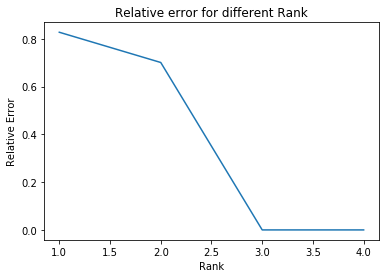

In [12]:
plt.plot(range(1, 5), errors)
plt.title('Relative error for different Rank')
plt.xlabel('Rank')
plt.ylabel('Relative Error');

We can clearly see that the tensor has rank 3.

### Task 10

First we should download and prepare data:

In [13]:
data_0 = scipy.io.loadmat('mnist_gabor_no0_1000.mat')['F']
data_1 = scipy.io.loadmat('mnist_gabor_no1_1000.mat')['F']
data_7 = scipy.io.loadmat('mnist_gabor_no7_1000.mat')['F']
tensor = np.concatenate((data_0, data_1, data_7), axis=4)
tensor = tl.tensor(tensor.reshape([28 * 28, 8, 4, 3000]))

Then we will apply CPD and train Random Forest Classifier:

In [14]:
accuracy = []
factors_dict = {}
for r in [2, 5, 10, 15]:
    weights, factors = parafac(tensor, rank=r, n_iter_max=10, init='random')
    factors_dict[r] = factors
    X = factors[-1]
    y = 1000 * [0] + 1000 * [1] + 1000 * [7]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
    clf = RandomForestClassifier(random_state = 1)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, preds))
    print("End of rank", r, "computation")

End of rank 2 computation
End of rank 5 computation
End of rank 10 computation
End of rank 15 computation


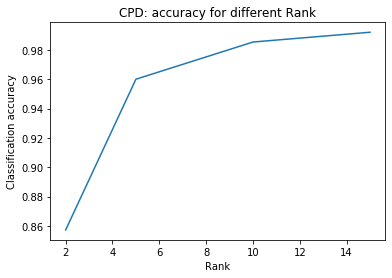

In [15]:
plt.plot([2, 5, 10, 15], accuracy)
plt.title('CPD: accuracy for different Rank')
plt.xlabel('Rank')
plt.ylabel('Classification accuracy');

Now we would like to make $\mathbf{A}$ and $\mathbf{B}$ factors orthogonal.

$$\min_{\mathbf{A}, \mathbf{B}, \mathbf{C}, \mathbf{D}} \|\mathbf{Y} - [\![ \mathbf{A}, \mathbf{B}, \mathbf{C}, \mathbf{D} ]\!] \|_{F}^{2}$$
$$\text{s.t.} \quad \mathbf{A}^T \mathbf{A} = I, \mathbf{B}^T \mathbf{B} = I$$

#### Update rule for A, B

Update rule for $\mathbf{A}$ is constructed as follow by fixing other matrices. Let $Z = \mathbf{D} \odot \mathbf{C} \odot \mathbf{B}$, then:

$$\min_{\mathbf{A}} \|\mathbf{Y}_{(1)} - \mathbf{A} Z^T \|_{F}^{2}$$
$$\text{s.t.} \quad \mathbf{A}^T \mathbf{A} = I$$

We can write $\|\mathbf{Y}_{(1)} - \mathbf{A} Z^T \|_{F}^{2} = \|\mathbf{Y}_{(1)}\|_{F}^{2} + \|Z^T\|_{F}^{2} - 2\text{tr}(AZ^T \mathbf{Y}_{(1)}^T)$. Then if $Q = Z^T \mathbf{Y}_{(1)}^T$ we can write update rule for $A$ as:

$$\min_{\mathbf{A}} \text{tr}(AQ)$$
$$\text{s.t.} \quad \mathbf{A}^T \mathbf{A} = I$$

then $\mathbf{A}^* = UV^T$, where $U$ and $V$ are matrices from SVD of $Q$. We can construct the same procedure for updating $\mathbf{B}$

#### Update rule for C, D

Then we can write $\|\mathbf{Y} - [\![ \mathbf{A}, \mathbf{B}, \mathbf{C}, \mathbf{D} ]\!] \|_{F}^{2} = \|\mathbf{Y}_{(1,2)} - (\mathbf{B} \odot \mathbf{A}) (\mathbf{D} \odot \mathbf{C})^T \|_{F}^{2}$. Matrix $\mathbf{B} \odot \mathbf{A}$ is orthogonal, because $\mathbf{B}, \mathbf{A}$ are orthogonal. Then $\|\mathbf{Y}_{(1,2)} - (\mathbf{B} \odot \mathbf{A}) (\mathbf{D} \odot \mathbf{C})^T \|_{F}^{2} = \| (\mathbf{B} \odot \mathbf{A})^T \mathbf{Y}_{(1,2)} - (\mathbf{D} \odot \mathbf{C})^T \|_{F}^{2} = \| \mathbf{Y}_{(1,2)}^T (\mathbf{B} \odot \mathbf{A}) - (\mathbf{D} \odot \mathbf{C}) \|_{F}^{2}$ and this is just the Khatri-Rao factorization described in the Task 3. For simplicity we will just use standard ALS scheme for updating $\mathbf{C}$ and $\mathbf{D}$ here.

In [16]:
def decompose_orthonormalAB(Y, rank, max_iter=100):
    
    B = np.random.random((rank, Y.shape[1]))
    C = np.random.random((rank, Y.shape[2]))
    D = np.random.random((rank, Y.shape[3]))
    
    Ya = tl.unfold(tensor, mode=0).T
    Yb = tl.unfold(tensor, mode=1).T
    Yc = tl.unfold(tensor, mode=2).T
    Yd = tl.unfold(tensor, mode=3).T

    for epoch in range(max_iter):
        
        # A update
        Z = khatri_rao([B.T, C.T, D.T])
        Q = Z.T @ Ya
        U, _, Vt = np.linalg.svd(Q, full_matrices=False)
        A = U @ Vt

        # B update
        Z = khatri_rao([A.T, C.T, D.T])
        Q = Z.T @ Yb
        U, _, Vt = np.linalg.svd(Q, full_matrices=False)
        B = U @ Vt
                            
        # C update
        Z = khatri_rao([A.T, B.T, D.T])
        C = tl.solve(Z.T.dot(Z), Z.T.dot(Yc))
        
        # D update
        Z = khatri_rao([A.T, B.T, C.T])
        D = tl.solve(Z.T.dot(Z), Z.T.dot(Yd))
            
    return A.T, B.T, C.T, D.T

In [17]:
accuracy = []
factors_dict_orth = {}
for r in [2, 5, 10, 15]:
    factors = decompose_orthonormalAB(tensor, rank=r, max_iter=10)
    factors_dict_orth[r] = factors
    X = factors[-1]
    y = 1000 * [0] + 1000 * [1] + 1000 * [7]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
    clf = RandomForestClassifier(random_state = 1)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, preds))
    print("End of rank", r, "computation")

End of rank 2 computation
End of rank 5 computation
End of rank 10 computation
End of rank 15 computation


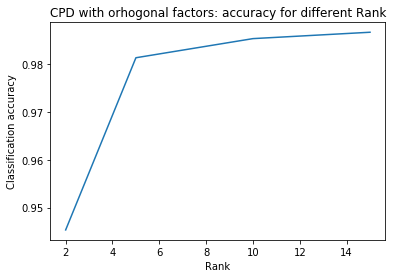

In [18]:
plt.plot([2, 5, 10, 15], accuracy)
plt.title('CPD with orhogonal factors: accuracy for different Rank')
plt.xlabel('Rank')
plt.ylabel('Classification accuracy');

So we see that CPD with two orthogonal factors results in slightly better classification accuracy than classical CPD. For example, for rank 5 accuracy for classical CPD is 0.96 and for CPD with two orthogonal factors is 0.98.

Now we would like to visualize components of A. We sample 3 columns from A and from orthogonal A:

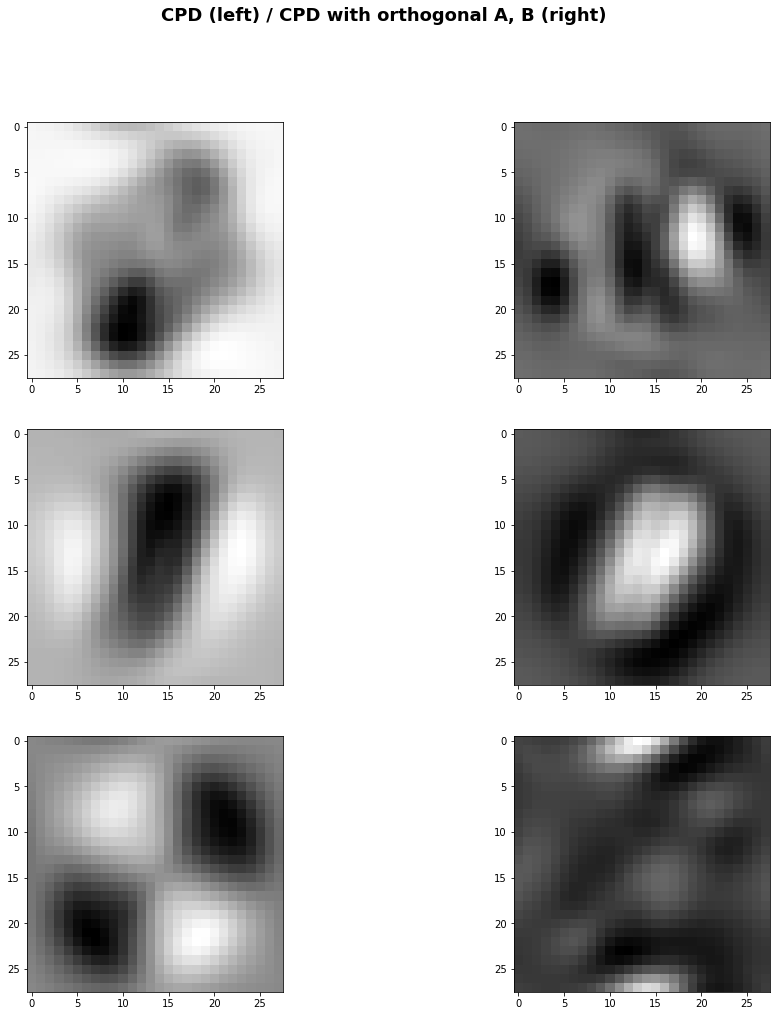

In [19]:
import random

rank = 15
N = 3
A = factors_dict[rank][0]
A_orth = factors_dict_orth[rank][0]
indices = random.sample(range(0, A.shape[1]), N)

fig, axes = plt.subplots(ncols = 2, nrows=N, figsize=(16, 16))
fig.suptitle('CPD (left) / CPD with orthogonal A, B (right)', fontsize=18, fontweight='bold')
for i in range(N):
    axes[i,0].imshow(A[:, indices[i]].reshape(28, 28), cmap='gray')
    axes[i,1].imshow(A_orth[:,indices[i]].reshape(28, 28), cmap='gray')

### Task 14

We have
$$\begin{aligned}
\mathbf{A} &=\left[\boldsymbol{a}_{11}, \ldots, \boldsymbol{a}_{1 R}, \ldots, \boldsymbol{a}_{S 1}, \ldots, \boldsymbol{a}_{S R}\right] \\
\mathbf{B} &=\left[\boldsymbol{b}_{11}, \ldots, \boldsymbol{b}_{1 R}, \ldots, \boldsymbol{b}_{S 1}, \ldots, \boldsymbol{b}_{S R}\right] \\
\mathbf{C} &=\left[\boldsymbol{c}_{1}, \ldots, \boldsymbol{c}_{S}\right] .
\end{aligned}$$
and we want to find the decomposition as follows:
$$\boldsymbol{X}=\sum_{s=1}^{S} \sum_{r=1}^{R} \boldsymbol{a}_{s, r} \circ \boldsymbol{b}_{s, r} \circ \boldsymbol{c}_{s}$$

We can extend $\tilde{C} = [C_1, \ldots, C_S]$, where $C_s = [c_s, c_s, \ldots, c_s]$ is a matrix of $R$ stacked columns. Now we get just the CP decomposition into three factors: $A, B$ and $\tilde{C}$. We can write $\min \|\boldsymbol{Y}-\boldsymbol{X}\|_{F}^{2}$ via unfolding as usual:

$$\min \|Y_{(1)} - A(\tilde{C} \odot B)^T \|_{F}^{2}$$
$$\min \|Y_{(2)} - B(\tilde{C} \odot A)^T \|_{F}^{2}$$
$$\min \|Y_{(3)} - \tilde{C}(B \odot A)^T \|_{F}^{2}$$

We can construct matrix $E = I_S \otimes [1,1, ..., 1]_R$ which will transform $\tilde{C} = CE$. Then we can rewrite:

$$\min \|Y_{(1)} - A(CE \odot B)^T \|_{F}^{2}$$
$$\min \|Y_{(2)} - B(CE \odot A)^T \|_{F}^{2}$$
$$\min \|Y_{(3)} - CE(B \odot A)^T \|_{F}^{2}$$

Taking gradient and setting it to zero gives us update rules:

$$A(CE \odot B)^T (CE \odot B) -  Y_{(1)}(CE \odot B) = 0 \qquad \Rightarrow \qquad A( (E^T C^T C E) * (B^TB)) -  Y_{(1)}(CE \odot B) = 0$$
$$B(CE \odot A)^T (CE \odot A) -  Y_{(2)}(CE \odot A) = 0 \qquad \Rightarrow \qquad B( (E^T C^T C E) * (A^TA)) -  Y_{(2)}(CE \odot A) = 0$$
$$CE(B \odot A)^T (B \odot A) E^T -  Y_{(3)}(B \odot A) E^T = 0 \qquad \Rightarrow \qquad C (E ((A^TA) * (B^TB)) E^T ) -  Y_{(2)}(B \odot A) E^T = 0$$

which we will solve for $A$, $B$ and $C$ respectively.

In [20]:
def BTD_ALS(tensor, R, S, num_iters = 100):
    I, J, K = tensor.shape
    A = np.random.random((I, R*S))
    B = np.random.random((J, R*S))
    C = np.random.random((K, S))
    E = np.kron(np.eye(S), np.ones((1, R)))
    norm = tl.norm(tensor)
    errors = []
    
    for i in range(num_iters):
        # Update A
        tempCE = tl.dot(C, E)
        tempECCE = tl.dot(tl.transpose(tempCE), tempCE)
        
        pseudo_inverse = tempECCE * tl.dot(tl.transpose(B), B)
        rhs = tl.dot(tl_unfold(tensor, 0), khatri_rao([B, tempCE]))
        A = tl.transpose(tl.solve(tl.transpose(pseudo_inverse), tl.transpose(rhs)))

        # Update B
        pseudo_inverse = tempECCE * tl.dot(tl.transpose(A), A)
        rhs = tl.dot(tl_unfold(tensor, 1), khatri_rao([A, tempCE]))
        B = tl.transpose(tl.solve(tl.transpose(pseudo_inverse), tl.transpose(rhs)))

        # Update C
        pseudo_inverse = tl.dot(tl.transpose(B), B) * tl.dot(tl.transpose(A), A)
        pseudo_inverse = tl.dot(E, pseudo_inverse)
        pseudo_inverse = tl.dot(pseudo_inverse, tl.transpose(E))
        rhs = tl.dot(tl_unfold(tensor, 2), khatri_rao([A, B]))
        rhs = tl.dot(rhs, tl.transpose(E))
        C = tl.transpose(tl.solve(tl.transpose(pseudo_inverse), tl.transpose(rhs)))
        
        factors = [A, B, tl.dot(C, E)]
        error = tl.norm(tensor - tl.cp_to_tensor(CPTensor((None, factors))))/norm
        errors.append(error)
        
    return A,B,C,errors

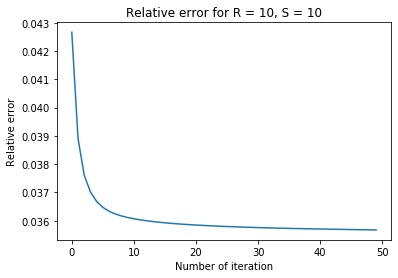

In [21]:
I, J, K = 100, 50, 40
tensor = tl.cp_to_tensor(random_cp((I,J,K), 100))
R, S = 10, 10
A,B,C,errors = BTD_ALS(tensor, R, S, num_iters = 50)
plt.plot(errors)
plt.title('Relative error for R = 10, S = 10')
plt.xlabel('Number of iteration')
plt.ylabel('Relative error');

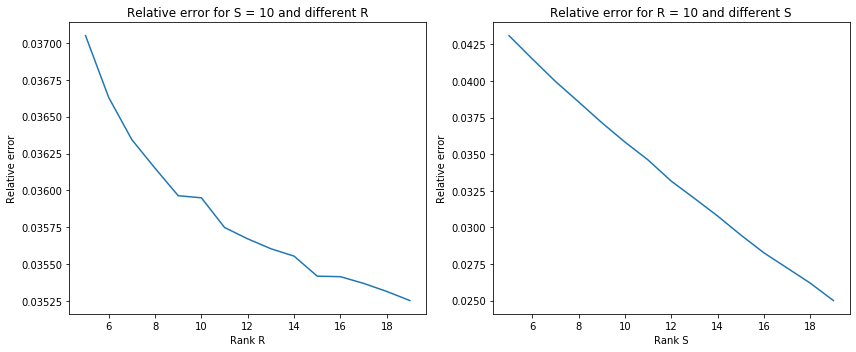

In [22]:
I, J, K = 100, 50, 40
tensor = tl.cp_to_tensor(random_cp((I,J,K), 100))

fig, axes = plt.subplots(ncols = 2, nrows=1, figsize=(12, 5), tight_layout=True)

S = 10
errors_list = []
R_list = range(5, 20)
for R in R_list:
    A,B,C,errors = BTD_ALS(tensor, R, S, num_iters = 20)
    errors_list.append(errors[-1])
axes[0].plot(R_list, errors_list)
axes[0].set_title('Relative error for S = 10 and different R')
axes[0].set_xlabel('Rank R')
axes[0].set_ylabel('Relative error')

R = 10
errors_list = []
S_list = range(5, 20)
for S in S_list:
    A,B,C,errors = BTD_ALS(tensor, R, S, num_iters = 20)
    errors_list.append(errors[-1])
axes[1].plot(S_list, errors_list)
axes[1].set_title('Relative error for R = 10 and different S')
axes[1].set_xlabel('Rank S')
axes[1].set_ylabel('Relative error');